## Installation and imports

In [21]:
# based upon:
# https://github.com/instadeepai/nucleotide-transformer/blob/main/examples/inference.ipynb

# I installed nucleotide-transformer using: 
# pip install git+https://github.com/instadeepai/nucleotide-transformer@main

# Another way to use nucleotide-transformer: 
# https://huggingface.co/InstaDeepAI/nucleotide-transformer-500m-human-ref?text=ACCTGA%3Cmask%3EAACTGAGTC

In [22]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

## Download the model 

One must specify: 

1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [31]:
model_name = '500M_human_ref' #@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']

parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    mixed_precision=False,
    embeddings_layers_to_save=(20,),
    attention_maps_to_save=((1, 4), (7, 18)),
    max_positions=200 # 32,
)
forward_fn = hk.transform(forward_fn)

In [40]:
# for inference: 
random_key = jax.random.PRNGKey(0)

## [TODO] Plot variant-effect prediction profile and observed SNV positions for windows with varying degrees of predicted constraint

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

In [6]:
import pandas as pd 

pd.set_option('display.max_columns', 50)

def get_windows_scores_annotations():
    filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment.bed'
    df = pd.read_csv(filename, sep='\t')
    df = df[df['window overlaps merged_exon'] == False]
    return df

windows_scores_annotations_noncoding = get_windows_scores_annotations()
windows_scores_annotations_noncoding

,chromosome,start,end,N_observed,N_bar_3_noncoding,N_mean_null_3_noncoding,N_variance_null_3_noncoding,cpg_island overlap,enhancer overlap,merged_exon overlap,window overlaps enhancer,window overlaps merged_exon,window overlaps cpg_island,new chen zscore,negative new chen zscore,eliteness_of_enhancer max,enhancer count,window_enhancer_overlap_bps sum,optimal_gene_targeted_by_enhancer <lambda>,optimal_enhancer_gene_association_score max,eliteness_of_optimal_enhancer_gene_association max
0,chr1,1432000,1433000,260,-0.247615,263.528599,203.072610,NaN,1000.0,NaN,True,False,False,4.299894,-4.299894,1.0,1,1000,VWA1,758.12,1.0
4,chr1,1451000,1452000,293,2.367303,260.131776,192.772432,NaN,NaN,NaN,False,False,False,0.666316,-0.666316,NaN,0,0,.,NaN,NaN
5,chr1,1453000,1454000,260,1.023579,245.832671,191.572571,NaN,NaN,NaN,False,False,False,0.828398,-0.828398,NaN,0,0,.,NaN,NaN
7,chr1,1458000,1459000,274,1.921190,247.467287,190.731630,NaN,NaN,NaN,False,False,False,-0.086128,0.086128,NaN,0,0,.,NaN,NaN
11,chr1,1463000,1464000,192,-2.085869,220.639685,188.522242,NaN,28.0,NaN,True,False,False,2.948188,-2.948188,1.0,1,28,ATAD3C,750.33,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785813,chr9,137262000,137263000,303,4.256927,244.570154,188.398345,45.0,346.0,NaN,True,False,True,-2.396149,2.396149,0.0,2,346,"DPH7,NELFB",23.85,1.0
1785814,chr9,137268000,137269000,215,-1.149755,230.788702,188.574204,NaN,1000.0,NaN,True,False,False,3.640544,-3.640544,1.0,1,1000,HSALNG0075385,750.64,1.0
1785815,chr9,137269000,137270000,210,-3.445370,257.657992,191.337298,NaN,1000.0,NaN,True,False,False,5.276351,-5.276351,1.0,1,1000,HSALNG0075385,750.64,1.0
1785816,chr9,137275000,137276000,296,1.921453,268.932391,198.445131,NaN,712.0,NaN,True,False,False,2.687348,-2.687348,1.0,2,712,"NELFB,EHMT1",762.48,1.0


In [56]:
import warnings
from numpy import linalg as LA

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/predict-constraint/germline-model')
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

import pysam 

from pack_unpack import pack 
from expected_observed_counts import compute_SNV_positions_frequencies
from read_model import read_model
from sequence import get_sequence

def compute_array_of_quantiles():
    array_of_quantiles = [0.00, 0.005, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.98, 0.99, 0.995, 1.00]
    # array_of_quantiles = [0.00, 0.01, 0.02, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.98, 0.99, 1.00]
    starts = array_of_quantiles[:-1]
    ends = array_of_quantiles[1:]
    quantile_labels = [f'{start} - {end}' for start, end in zip(starts, ends)]
    return array_of_quantiles, quantile_labels

def label_windows_with_score_quantiles_core(df, score): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")        

        array_of_quantiles, quantile_labels = compute_array_of_quantiles()

        df[f'{score} quantile'], bins = pd.qcut(
            df[score],
            q = array_of_quantiles, 
            labels = quantile_labels, 
            retbins = True,
    #         duplicates='drop'
        )

        return df

def get_snvs_and_sequence(region): 
  model_filename=f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json"
  model = read_model(model_filename)
  with pysam.TabixFile(model['mutations']) as mutations, pysam.FastaFile(model['genome']) as genome:
    (
      SNV_positions_frequencies_CpG_positive, 
      SNV_positions_frequencies_CpG_negative
    ) = compute_SNV_positions_frequencies(mutations, genome, region, model)
  sequence = get_sequence(region, model)
  return (
    SNV_positions_frequencies_CpG_positive, 
    SNV_positions_frequencies_CpG_negative,
    sequence
  )

def f(df, score='negative new chen zscore'):
  df = label_windows_with_score_quantiles_core(df, score)
  df = ( 
    df
    .groupby([f'{score} quantile'], as_index=True)
    .apply(lambda df_subset: df_subset.sample())
    .reset_index(drop=True)
  )
  for index, row in df.iterrows():  
    # TODO: 
    # 1. loop over sites in window 
    # 2. for each site, loop over possible ALT alleles 
    # 3. for each ALT allele, obtain a 6kbp sequence centered on that site, and call that "ref_sequence"
    # 4. create an "alt_sequence", carrying the ALT allele at the given position
    # 5. compute distance between embeddings  
    #    (i) the L1 distance (Manhattan), 
    #    (ii) the L2 distance (Eu- clidean), 
    #    (iii) the cosine similarity 
    #    (iv) the dot-product (not normalized cosine similarity) 

    region = pack(row['chromosome'], row['start'], row['end'])
    (
      SNV_positions_frequencies_CpG_positive, 
      SNV_positions_frequencies_CpG_negative,
      ref_sequence # mixed case
    ) = get_snvs_and_sequence(region)
    ref_sequence = ref_sequence.upper()

    alt_sequence = ref_sequence 

    # Tokenize sequence(s)
    # The `tokens_str` variable shows how sequence(s) have been split into tokens. 
    # The token list will be padded to size `max_positions`.
    sequences = [
        ref_sequence,
        alt_sequence
    ]
    tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
    # tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)
    
    # Perform Inference
    # The first time you query this cell, it will be slower than usual because of the computation graph compilation.        
    outs = forward_fn.apply(parameters, random_key, tokens)        
    print(outs.keys())

    # Retrieve embeddings
    print(outs["embeddings_20"].shape)

    embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
    padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
    masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
    sequences_lengths = jnp.sum(padding_mask, axis=1)
    mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths
    print(mean_embeddings)
    ref_embedding = mean_embeddings[0,:]
    alt_embedding = mean_embeddings[1,:]
    delta = ref_embedding - alt_embedding
    distance = LA.norm(delta, 2)

    # TODO
    # 1. add distance to nested dictionary 
    # 2. once dictionary is populated, cast it as a 2D array 
    # 3. plot 4*L array as a heat map with seaborn 
    #     experiments/germline-model/chen-et-al-2022/interplay-of-constraint-and-sequence-feature-composition.1.ipynb
    heat_map[position][allele] = distance   
    
    return 

    # TODO: 
    # plot locations of observed SNVs (use web-browser plotly.js code???)

f(windows_scores_annotations_noncoding)

dict_keys(['attention_map_layer_1_number_4', 'attention_map_layer_7_number_18', 'embeddings_20', 'logits'])
(2, 200, 1280)
[[ 0.54524916 -1.46304    -1.386075   ...  3.406688    1.2388867
  -2.3737302 ]
 [ 0.54524916 -1.46304    -1.386075   ...  3.406688    1.2388867
  -2.3737302 ]]
[3, 4]
7.0


## [TODO] Hypothesis test
outlined in 2a: https://docs.google.com/presentation/d/1naB2zEBWXLoQOP9ioMDe77FlP8dhb63Eu8P_G6Jdpac/edit#slide=id.g22afc145c47_0_8

## [Other resources] Get attention maps
Here is an example on how to retrieve attention maps at a specific layer for a given head and how to plot them.

In [10]:
print(outs["attention_map_layer_1_number_4"].shape)

(2, 32, 32)


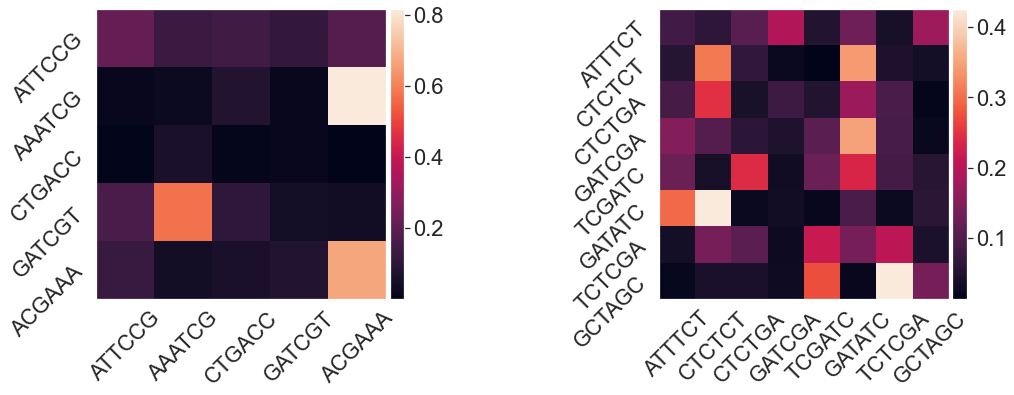

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns 

sns.set_theme(
    font_scale=2,
    rc={'figure.figsize': (16, 6)}
)

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0]), int(sequences_lengths[1])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1:(seq_length0 + 1), 1:(seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)))
axes[0].set_xticklabels(tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)))
axes[0].set_yticklabels(tokens0, rotation=45)
axes[0].grid(False)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1:(seq_length1 + 1), 1:(seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)))
axes[1].set_xticklabels(tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)))
axes[1].set_yticklabels(tokens1, rotation=45)
axes[1].grid(False)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

## [Other resources] Get probabilities
Finally, let's look at the model probabilities over the vocabulary at each position. These can be used to compute reconstruction accuracies and perplexities.

In [12]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

(5, 4105)
(8, 4105)


Let's look in particular at a given sequence and position and show the top-k probabilities and corresponding tokens.

In [13]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: CTTCCT, probability: 26.59%
token: CTTTCT, probability: 9.63%
token: TTTCCT, probability: 4.15%
token: CTTCTC, probability: 3.31%
token: CTTTTC, probability: 2.59%
